In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import pandas as pd

import time
from datetime import timedelta

import math
import os

import scipy.misc
from scipy.stats import itemfreq
from random import sample
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Image manipulation
import PIL.Image
from IPython.display import display

# Open a Zip File
from zipfile import ZipFile
from io import BytesIO

In [2]:
import keras

Using TensorFlow backend.


In [3]:
# We unzip the train and test zip file
archive_train = ZipFile("./data/train.zip", 'r')
archive_test = ZipFile("./data/test.zip", 'r')
# This line shows the 5 first image name of the train database
archive_train.namelist()[0:5]
# This line shows the number of images in the train database, noted that we must remove the 1st value (column header)
len(archive_train.namelist()[:]) - 1

10222

In [30]:
# This function help to create  a pickle file gathering all the image from a zip folder
def DataBase_creator(archivezip, nwidth, nheight, save_name):
    # We choose the archive (zip file) + the new width and height for all the image which will be reshaped
    
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    # nwidth x nheight = number of features because images have nwidth x nheight pixels
    s = (len(archivezip.namelist()[:])-1, nwidth, nheight,3)
    allImage = np.zeros(s)
    for i in range(1,len(archivezip.namelist()[:])):
        filename = BytesIO(archivezip.read(archivezip.namelist()[i]))
        image = PIL.Image.open(filename) # open colour image
        image = image.resize((nwidth, nheight))
        image = np.array(image)
        image = np.clip(image/255.0, 0.0, 1.0) # 255 = max of the value of a pixel
        allImage[i-1]=image
    
    # we save the newly created data base
    pickle.dump(allImage, open( 'data/' + save_name + '.pkl', "wb" ) )
    
    # Ending time.
    end_time = time.time()
    # Difference between start and end-times.
    time_dif = end_time - start_time
    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [31]:
image_resize = 80
DataBase_creator(archivezip = archive_train, nwidth = image_resize, nheight = image_resize , save_name = "train")
DataBase_creator(archivezip = archive_test, nwidth = image_resize, nheight = image_resize , save_name = "test")

Time usage: 0:00:42
Time usage: 0:00:41


In [32]:
train = pickle.load( open( "data/train.pkl", "rb" ) )
test = pickle.load( open( "data/test.pkl", "rb" ) )
train.shape

(10222, 80, 80, 3)

In [33]:
test.shape

(10357, 80, 80, 3)

In [34]:
labels_raw = pd.read_csv("./data/labels.csv", header=0, sep=',', quotechar='"')
labels_raw.sample(5)

,id,breed
3281,5172a8db62a1928c1067c36f6bf274a3,lhasa
905,162a3de12cc110679a921dc49dd38fc8,black-and-tan_coonhound
5742,910bd1cbf310a280b98777fda080a929,miniature_schnauzer
5988,970df71375e17e998d03900b2e3557bb,lhasa
8312,d015ddbcda957741a34c705200094e5e,border_collie


In [35]:
Nber_of_breeds = 8

# Get the N most represented breeds
def main_breeds(labels_raw, Nber_breeds , all_breeds='TRUE'):
    labels_freq_pd = itemfreq(labels_raw["breed"])
    labels_freq_pd = labels_freq_pd[labels_freq_pd[:, 1].argsort()[::-1]]
    
    if all_breeds == 'FALSE':
        main_labels = labels_freq_pd[:,0][0:Nber_breeds]
    else: 
        main_labels = labels_freq_pd[:,0][:]
        
    labels_raw_np = labels_raw["breed"].as_matrix()
    labels_raw_np = labels_raw_np.reshape(labels_raw_np.shape[0],1)
    labels_filtered_index = np.where(labels_raw_np == main_labels)
    return labels_filtered_index

labels_filtered_index = main_breeds(labels_raw = labels_raw, Nber_breeds = Nber_of_breeds, all_breeds='FALSE')
labels_filtered = labels_raw.iloc[labels_filtered_index[0],:]
train_filtered = train[labels_filtered_index[0],:,:,:]
print('- Number of images remaining after selecting the {0} main breeds : {1}'.format(Nber_of_breeds, labels_filtered_index[0].shape))
print('- The shape of train_filtered dataset is : {0}'.format(train_filtered.shape))

- Number of images remaining after selecting the 8 main breeds : (922,)
- The shape of train_filtered dataset is : (922, 80, 80, 3)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


In [36]:
# We select the labels from the N main breeds
labels = labels_filtered["breed"].as_matrix()
labels = labels.reshape(labels.shape[0],1) #labels.shape[0] looks faster than using len(labels)
labels.shape

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


(922, 1)

In [37]:
def matrix_Bin(labels):
    labels_bin=np.array([])

    labels_name, labels0 = np.unique(labels, return_inverse=True)
    labels0
    
    for _, i in enumerate(itemfreq(labels0)[:,0].astype(int)):
        labels_bin0 = np.where(labels0 == itemfreq(labels0)[:,0][i], 1., 0.)
        labels_bin0 = labels_bin0.reshape(1,labels_bin0.shape[0])

        if (labels_bin.shape[0] == 0):
            labels_bin = labels_bin0
        else:
            labels_bin = np.concatenate((labels_bin,labels_bin0 ),axis=0)

    print("Nber SubVariables {0}".format(itemfreq(labels0)[:,0].shape[0]))
    labels_bin = labels_bin.transpose()
    print("Shape : {0}".format(labels_bin.shape))
    
    return labels_name, labels_bin

In [38]:
labels_name, labels_bin = matrix_Bin(labels = labels)
labels_name[labels_bin[1].argmax()]

Nber SubVariables 8
Shape : (922, 8)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  app.launch_new_instance()


'maltese_dog'

In [39]:
print(train_filtered.shape)
print(labels_bin.shape)
print(labels_name.shape)

(922, 80, 80, 3)
(922, 8)
(8,)


In [40]:
X = train_filtered
y = labels_bin

In [41]:
# pickle.dump(X_train, open("pickles/X_train_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "wb"))
# pickle.dump(X_test, open("pickles/X_test_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "wb"))
# pickle.dump(y_train, open("pickles/y_train_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "wb"))
# pickle.dump(y_test, open("pickles/y_test_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "wb"))

pickle.dump(X, open("pickles/X_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "wb"))
pickle.dump(y, open("pickles/y_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "wb"))
pickle.dump(labels_name, open("pickles/labels_name_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "wb"))

In [42]:
print("pickles/X_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl")

pickles/X_80x80_8.pkl


In [28]:
num_validation = 0.30
X_train, X_test, y_train, y_test = train_test_split(train_filtered, labels_bin, test_size=num_validation, random_state=6)

In [29]:
X_train.shape

(645, 64, 64, 3)

In [30]:
X_test.shape

(277, 64, 64, 3)

In [31]:
y_train.shape

(645, 8)

In [32]:
y_test.shape

(277, 8)

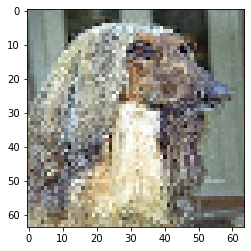

In [33]:
plt.imshow(X_train[8])

In [34]:
labels_name[y_train[8].argmax()]

'afghan_hound'

In [21]:
X_train = pickle.load(open("pickles/X_train.pkl", "rb"))